### Import libraries

In [1]:
%pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 6)
import QuantLib as ql
import pandas as pd
import scipy.interpolate
import pandas as pd
import numpy as np

import math
#import utils

from datetime import timedelta
import datetime
import matplotlib. pyplot as plt 
import pdblp

In [317]:
obsdate = '2020-10-19'   # yyyy-mm-dd format
obs_date = datetime.datetime.strptime(obsdate, '%Y-%m-%d')
today = ql.Date(19, 10, 2020) # d m yyyy format
ql.Settings.instance().evaluationDate = today

### Initiate pbblp

In [2]:
con = pdblp.BCon(debug=False, port=8194, timeout=5000)  #debug = True prints all the Response and Request messages

### Initial definitions ands parametrizations 

In [19]:
timedelta_days = 1 
# NOTE: Default timedelta is 1 (yesterday), however, I have to check what 
# happens if we try to get todays data. Also, I have to check what happens if 
# -1 is a weekend: is there any data there or an error will appear?

# Define last date of data colllection from BBG
date_until = datetime.strftime(datetime.now() - timedelta(timedelta_days), '%Y%m%d')

# List all the tickers we want to consult
tickers_EONIA = ["EUSWEA Curncy", "EUSWEB Curncy", "EUSWEC Curncy", "EUSWED Curncy", 
                 "EUSWEE Curncy", "EUSWEF Curncy", "EUSWEI Curncy", "EUSWE1 Curncy", 
                 "EUSWE1F Curncy", "EUSWE2 Curncy", "EUSWE3 Curncy", "EUSWE4 Curncy", 
                 "EUSWE5 Curncy", "EUSWE6 Curncy", "EUSWE7 Curncy", "EUSWE8 Curncy", 
                 "EUSWE9 Curncy", "EUSWE10 Curncy", "EUSWE12 Curncy", "EUSWE15 Curncy", 
                 "EUSWE20 Curncy", "EUSWE25 Curncy", "EUSWE30 Curncy", "EUSWE40 Curncy", 
                 "EUSWE50 Curncy"]

tickers_ESTR = ["EESWEA Curncy", "EESWEB Curncy", "EESWEC Curncy", "EESWED Curncy", 
                 "EESWEE Curncy", "EESWEF Curncy", "EESWEI Curncy", "EESWE1 Curncy", 
                 "EESWE1F Curncy", "EESWE2 Curncy", "EESWE3 Curncy", "EESWE4 Curncy", 
                 "EESWE5 Curncy", "EESWE6 Curncy", "EESWE7 Curncy", "EESWE8 Curncy", 
                 "EESWE9 Curncy", "EESWE10 Curncy", "EESWE12 Curncy", "EESWE15 Curncy", 
                 "EESWE20 Curncy", "EESWE25 Curncy", "EESWE30 Curncy", "EESWE40 Curncy", 
                 "EESWE50 Curncy"]

terms = [1, 2, 3, 4, 5, 6, 9, 12, 18, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 40, 50]



### Let's start!

###### Note: Make sure that you are logged in to a Bloomberg terminal

In [20]:
# Start a connection
con.start()

# First create an empty dataframe
df = pd.DataFrame()

In [21]:
# With bdh we access historical data 
# "PX_LAST" is the last traded price for a security. This updates when you set 
# up the BDP/BDH formula and when you refresh the workbook. If you want a live,
# streaming, price, use "LAST_PRICE".

# Default goes with EONIA. If ESTR wanted change for tickers_ESTR
for ticker in tickers_EONIA: 
    temp_data = con.bdh(ticker, ['PX_LAST'], '20201001', date_until, 
                                longdata=True)
    df = df.append(temp_data)
  
OIS_rate = df[df['Date']==obs_date]['Rate'].to_list() 

pdblp.pdblp:WARNING:Unexpected Event Type: 'TIMEOUT'


RuntimeError: Timeout, increase BCon.timeout attribute

In [320]:
calendar = ql.TARGET()
bussiness_convention = ql.ModifiedFollowing
day_count = ql.Actual360()
settlement_days_EONIA = 2
EONIA = ql.OvernightIndex("EONIA", settlement_days_EONIA, ql.EURCurrency(), calendar, day_count)

In [321]:
# Deposit Helper
depo_facility = -0.50
depo_helper = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(depo_facility/100)), ql.Period(1,ql.Days), 1, calendar, ql.Unadjusted, False, day_count)]

# OIS Helper
OIS_helpers = []
for i in range(len(terms)):
    if i < 8:
        tenor = ql.Period(terms[i],ql.Months)
        rate = OIS_rate[i]
        OIS_helpers.append(ql.OISRateHelper(settlement_days_EONIA, tenor, ql.QuoteHandle(ql.SimpleQuote(rate/100)), EONIA))
    elif i == 8:
        tenor = ql.Period(terms[i],ql.Months)
        rate = OIS_rate[i]
        OIS_helpers.append(ql.OISRateHelper(settlement_days_EONIA, tenor, ql.QuoteHandle(ql.SimpleQuote(rate/100)), EONIA))
    else:
        tenor = ql.Period(terms[i],ql.Years)
        rate = OIS_rate[i]
        OIS_helpers.append(ql.OISRateHelper(settlement_days_EONIA, tenor, ql.QuoteHandle(ql.SimpleQuote(rate/100)), EONIA))

##### _Merge both helpers_

In [337]:
rate_helpers = depo_helper + OIS_helpers
rate_helpers_alt = rate_helpers

In [338]:
eonia_curve_c_alt = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(), rate_helpers_alt, day_count)
eonia_curve_c_alt.enableExtrapolation()

In [339]:
# Don't drop indexes 0 and 1 
dropped_indexes = [10, 14, 16, 22, 24]
for i in sorted(dropped_indexes, reverse=True):
    del rate_helpers[i]

eonia_curve_c = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(), rate_helpers, day_count)
eonia_curve_c.enableExtrapolation()

### Obtain zero curve on a daily grid

In [340]:
all_days = ql.MakeSchedule(
    eonia_curve_c.referenceDate(),
    eonia_curve_c.maxDate(),
    ql.Period('1D')
    )

tenors = []
spots = []
for d in all_days:
    yrs = day_count.yearFraction(today, d)
    compounding = ql.Compounded
    freq = ql.Semiannual
    zero_rate = eonia_curve_c.zeroRate(yrs, compounding, freq)
    tenors.append(yrs)
    eq_rate = zero_rate.equivalentRate(day_count,compounding,freq,today,d).rate()
    spots.append(100*eq_rate)
    
cal = ql.NullCalendar()
days_to_maturity = [cal.businessDaysBetween(today, d) for d in all_days]

datatable = {'Tenors':tenors,'spots':spots}
df_spots = pd.DataFrame.from_dict(datatable)

df_spots = df_spots.assign(dtm=days_to_maturity)
df_spots['dates_2'] =  obs_date + pd.to_timedelta(df_spots['dtm'], unit='d')
    
# Drop O/N 1-d
df_spots = df_spots[30:]


##### Obtain zero rates only on input tenor (for plotting purposes)

In [342]:
def plot_fwd_curve_cmt(year, month, day):
    fig, ax = plt.subplots()
    xlim =  datetime.datetime(year, month, day)
    date_string = year_lim + "-" +  month_lim + "-" + day_lim
    date_lim = datetime.datetime.strptime(date_string, "%Y-%m-%d")
    major_ticks = np.arange(-0.8, 3.4, 0.05)
    ax.set_yticks(major_ticks)
    axhline(0, linestyle = '-', linewidth = 0.75, color = 'black')
    ax.grid(color='silver', linestyle='--', linewidth=0.75)
    xlabel('Maturity'), ylabel('Interest rate (in (%))'), grid(True)
    ax.plot(df_spots['dates_2'], df_spots['spots'], label='Spot Rate Curve (zero curve)', color='r')
    if show_label_marks == True:
        ax.plot(df_alt['dates_2'], df_alt['spots'], '^', label='Points in Spot Curve', color = 'b')
    points = len(df_alt[df_alt["dates_2"] <= date_lim])
    ax.set_xlim([df_spots['dates_2'].min()- timedelta(days=40), datetime.datetime.date(xlim)])
    xs, ys = df_alt['dates_2'][:points], df_alt['spots'][:points]
    if show_index_labels == True:
        for x,y in zip(xs,ys):
            label = next(iter(df_alt[df_alt['spots']==y].index), 'no match')
            plt.annotate(label, # this is the text
            (x,y), # this is the point to label
            textcoords="offset points", # how to position the text
            xytext=(0,10), # distance from text to points (x,y)
            ha='center') # horizontal alignment can be left, right or center
    ax.set_xlim([df_spots['dates_2'].min(), datetime.datetime.date(xlim)])
    ax.legend(loc=4)
    plt.show()

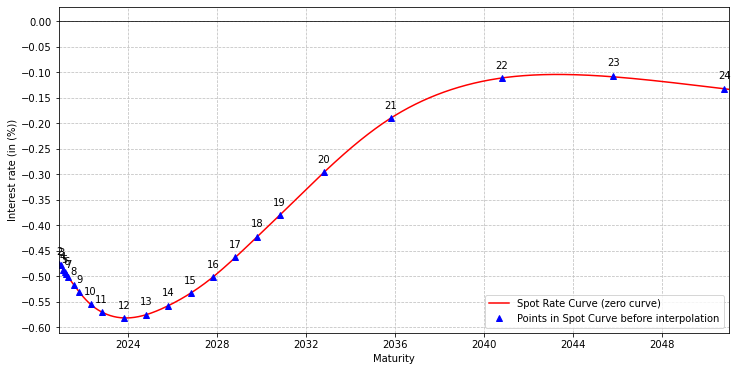

In [343]:
show_index_labels = True
show_label_marks = True
year_lim, month_lim, day_lim = "2050", "12", "31"
plot_fwd_curve_cmt(int(year_lim), int(month_lim), int(day_lim))

### Obtain the forward curve

In [344]:
rates_fwd = [
    eonia_curve_c.forwardRate(d, calendar.advance(d,1,ql.Days), day_count, ql.Simple).rate()*100
    for d in all_days
]

In [345]:
cal = ql.NullCalendar()
days_to_maturity = [cal.businessDaysBetween(today, d) for d in all_days]
datatable = {'forwards':rates_fwd}

In [346]:
df_forward = pd.DataFrame.from_dict(datatable)

df_forward = df_forward.assign(dtm=days_to_maturity)
df_forward['dates_2'] =  obs_date + pd.to_timedelta(df_forward['dtm'], unit='d')
df_forward['dates_2'] = pd.to_datetime(df_forward['dates_2'], format='%Y-%m-%d')
df_forward = df_forward[30:]

In [348]:
def plot_fwd_curve(year, month, day):
    fig, ax = plt.subplots()
    xlim =  datetime.datetime(year, month, day)
    
    date_string = year_lim + "-" +  month_lim + "-" + day_lim
    date_lim = datetime.datetime.strptime(date_string, "%Y-%m-%d")

    major_ticks = np.arange(-0.8, 3.4, 0.05)
    ax.set_yticks(major_ticks)
    axhline(0, linestyle = '-', linewidth = 0.75, color = 'black')
    ax.grid(color='silver', linestyle='--', linewidth=0.75)

    xlabel('Maturity', fontsize=16), ylabel('Interest rate (in %)', fontsize=16), grid(True)

    ax.plot(df_forward['dates_2'], df_forward['forwards'], label='Forward Curve', color = 'b')
    if plot_zero_curve == True:
        ax.plot(df_spots['dates_2'], df_spots['spots'], label='Zero curve', color = 'r')
    if plot_cmt == True:
        ax.plot(df_cmt['date'], df_cmt['rate'], label='CMT Forward Curve' + cmt_file, color = 'green')
    if show_label_marks == True:
        ax.plot(df_alt['dates_2'], df_alt['spots'], '^', label='Points in Spot Curve before interpolation', color = 'b')
        
    points = len(df_forward[df_forward["dates_2"] <= date_lim])
    ax.set_xlim([df_forward['dates_2'].min()- timedelta(days=40), datetime.datetime.date(xlim)])

    xs, ys = df_alt['dates_2'][:points], df_alt['spots'][:points]
    if show_index_labels == True:
        for x,y in zip(xs,ys):
            label = next(iter(df_alt[df_alt['spots']==y].index), 'no match')
            plt.annotate(label, # this is the text
            (x,y), # this is the point to label
            textcoords="offset points", # how to position the text
            xytext=(0,10), # distance from text to points (x,y)
            ha='center') # horizontal alignment can be left, right or center
    legend(loc=4, fontsize=10)
    
    plt.figtext(0.5, -0.01, "Dropped indexes: " + '; '.join([str(elem) for elem in dropped_indexes])  , ha="center", fontsize=12, bbox={"facecolor":"steelblue", 'edgecolor':'red', "alpha":0.5, "pad":5})

   
    if download_data == True:
        spline.to_csv('smoothed_forward_curve.csv')
    
    if download_image == True:
        plt.savefig('forward_curve_' + str(obsdate) + '.pdf', bbox_inches='tight')
    
    plt.show()

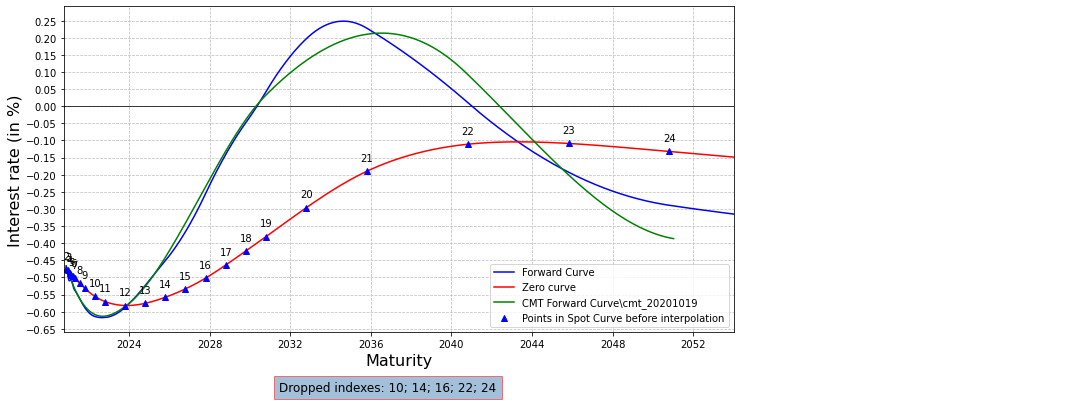

In [349]:
download_data = False
download_image = False
plot_zero_curve = True
plot_cmt = True
show_label_marks = True
show_index_labels = True
year_lim, month_lim, day_lim = "2053", "12", "31"
plot_fwd_curve(int(year_lim), int(month_lim), int(day_lim))